In [51]:
#import libraries
import numpy as np
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats, special

#allows Jupyter to render graphs inline
%matplotlib inline

In [116]:
'''
Node class represents a single point in the TSP graph
name: node number
x: x coordinate
y: y coordinate
'''
class Node:
    #Constructor for the class
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y
     
    '''
    Computes the euclidean distance between this node and a given node
    Input: Node object
    Output: float distance
    '''
    def distance(self, node):
        return math.sqrt((self.x-node.x)**2 + (self.y-node.y)**2)

'''
Individual class represents a path and is a member of the population
path: list of nodes
distance: overall path length
fitness: 1/distance
'''    
class Individual:
    #Constructor
    def __init__(self, path):
        self.path = path
        self.distance = 0.0
        self.fitness = 0.0
    
    '''
    Computes the path length of the individual
    Input: None
    Output: float path_length
    '''
    def path_length(self):
        pl = 0
        for i in range(0, len(self.path)):
            node1 = self.path[i]
            node2 = None
            if i+1 < len(self.path):
                node2 = self.path[i+1]
            else:
                node2 = self.path[0]
            pl = pl + node1.distance(node2)
            self.distance = pl
            self.fitness = 1/float(pl)
        return pl
    
    '''
    Returns the object's path as a list of strings
    Input: None
    Output: list path
    '''
    def get_path(self):
        path_list = []
        for i in self.path:
            path_list.append(i.name)
        return path_list

'''
Creates the first population by random selection of paths
Input: int population_size, list collection_of_nodes
Output: list collection_of_individuals
'''
def initialize_pop(pop_size, nodes):
    population = []
    for i in range(0, pop_size):
        route = random.sample(nodes, len(nodes))
        individual = Individual(route)
        population.append(individual)
    return population

'''
Reads in a .tsp file and creates the collection of Nodes
Input: string file_name
Output: list collection_of_nodes
'''
def read_tsp(file_name):
    nodes = []
    with open(file_name, "r") as file:
        data = file.readlines()
        
    for i in data:
        split_i = i.split(" ")
        if len(split_i) == 3:
            nodes.append(Node(int(split_i[0]), float(split_i[1]), float(split_i[2])))
    return nodes

'''
Computes the fitness values for a population within each individual
Input: list population_of_individuals
Output: None
'''
def find_fitnesses(population):
    for i in range(0, len(population)):
        population[i].path_length()

'''
Performs an elite ranking of the popluation.  The population is sorted based on fitness and 
the top gen_size is returned as a mating pool
Input: list population_of_individuals, int gen_size
Output: list sorted_and_filtered_population
'''
def rank_population_elite(population, gen_size):
    sorted_pop = sorted(population, key=lambda x: x.fitness, reverse=True)
    return sorted_pop[:gen_size]
    
    
'''
Ranks the population and selects individuals for futher ranking based on a probability
scaled based on each individual's fitness score
Input: list population_of_individuals, int gen_size
Output: list ranked_population_of_individuals
'''    
def rank_population_proportional(population, gen_size):
    selected = []
    pop_list = []
    for i in range(0, len(population)):
        pop_list.append((i, population[i].fitness))
        
    df = pd.DataFrame(pop_list, columns=["Individual", "Fitness"])
    df['breeding_chance'] = df.Fitness/df.Fitness.sum()
    for i in range(0, gen_size):
        selection = random.uniform(0,1)
        j = 0
        while True:
            row = df.iloc[j]
            selection -= row['breeding_chance']
            if selection < 0:
                break
            j+=1
        selected_row = df.iloc[j]
        selected.append(int(selected_row['Individual']))
        selected_prob = selected_row['breeding_chance']
        df = df.drop(j)
        df = df.reset_index(drop=True)
        if len(df) > 0:
            df["breeding_chance"] += selected_prob/len(df)
        
    return [population[i] for i in selected]

'''
Helper function that breeds two parents using one-point crossover
Input: Individual parent1, Individual parent2, list collection_of_nodes
Output: Individual child
'''
def breed(parent1, parent2, nodes):
    
    p1_path = parent1.get_path()
    p2_path = parent2.get_path()
    
    gene1 = int(random.random()*len(p1_path))
    gene2 = int(random.random()*len(p1_path))
    
    start_idx = min(gene1, gene2)
    end_idx = max(gene1, gene2)
    
    segment_p1 = p1_path[start_idx:end_idx]
    segment_p2 = [i for i in p2_path if i not in segment_p1]
    
    new_path = segment_p1 + segment_p2
    child_path = []
    
    for i in new_path:
        for j in nodes:
            if j.name == i:
                child_path.append(Node(i, j.x, j.y))
    
    
    child = Individual(child_path)
    
    return Individual(child_path)

'''
Uses the breed() function to breed random pairs of individuals within a population
Input: list pool_of_parents, list collection_of_nodes
Output: list next_generation
'''
def breed_pop(pool, size, nodes):
    children = []
    
    for i in pool:
        children.append(i)
    
    while len(children) != size:
        parents = random.sample(pool, 2)
        child = breed(parents[0], parents[1], nodes)
        children.append(child)
        
    return children

'''
Performs an in-place swap mutation in an individual
Input: Individual i
Output: None
'''
def mutate(individual):
    num_nodes = len(individual.path)
    idx1 = int(random.random()*num_nodes)
    idx2 = int(random.random()*num_nodes) 
    individual.path[idx1], individual.path[idx2] = individual.path[idx2], individual.path[idx1]

'''
Rolls for whether an individual should be mutate based on the mut_rate.  If 
the random roll is smaller, then individual is mutated.  This function is performed across
the population
Input: list population_of_individuals, float mut_rate
Output: None
'''
def mutate_population(population, mut_rate):
    for i in population:
        chance = random.random()
        if chance <= mut_rate:
            mutate(i)

'''
Collection of previous methods to make a new generation.  It takes a population,
selects the mating pool, breeds them, and performs mutations across that generation
Input: list current_generation, float mut_rate, int desired_population_size,
    int ranked_selection_size, object method_of_selection, list collection_of_nodes
Output: list new_generation_of_individuals
'''
def make_generation(curr_gen, mut_rate, pop_size, select_size, selection_method, nodes):
    pop_to_breed = selection_method(curr_gen, select_size)
    new_generation = breed_pop(pop_to_breed, pop_size, nodes)
    mutate_population(new_generation, mut_rate)
    return new_generation

'''
Runs make_generation() for num_generations and records the results
Input: list collection_of_nodes, int, number_of_generations, float mut_rate, int desired_population_size,
    int ranked_selection_size, object method_of_selection
Output: float best_distance, list best_path
'''
def run_ga_tsp(nodes, num_generations, mut_rate, pop_size, select_size, selection_method):
    start_time = time.time()
    avg_gen_fit_list = []
    best_gen_fit_list = []
    
    pop = initialize_pop(pop_size, nodes)
    find_fitnesses(pop)
    
    best_fit = 0
    best_path = 0
    best_dist = math.inf
    
    for i in range(0, num_generations):
        pop = make_generation(pop, mut_rate, pop_size, select_size, selection_method, nodes)
        find_fitnesses(pop)
        
        best_gen_fit = 0
        sum_gen_fit = 0
        for j in pop:
            if j.fitness > best_gen_fit:
                best_gen_fit = j.fitness
            if best_gen_fit > best_fit:
                best_fit = best_gen_fit
                best_path = j.get_path()
            if j.distance < best_dist:
                best_dist = j.distance
            sum_gen_fit += j.fitness
        avg_gen_fit = sum_gen_fit/len(pop)
        best_gen_fit_list.append(best_gen_fit)
        avg_gen_fit_list.append(avg_gen_fit)
        
    print("Execution time: " + str(time.time()-start_time))
    
    fig, ax = plt.subplots(2, figsize=(12,12))
    ax[0].plot(range(1, len(avg_gen_fit_list)+1), avg_gen_fit_list)
    ax[0].set_title("Average Fitness by Generation")
    ax[1].plot(range(1, len(best_gen_fit_list)+1), best_gen_fit_list)
    ax[1].set_title("Best Fitness by Generation")
    
    fig.text(0.5, 0.04, "Generation", ha="center")
    fig.text(0.04, 0.5, "Fitness Scores", va="center", rotation=90)
    
    print("Best Overall Fitness: " + str(best_fit))
    print("Best Path: " + str(best_path))
    print("Best Overall Distance: " + str(best_dist))
    
    return (best_dist, best_path)

def count_connections(paths, n_cities):
    adj_matrix = np.zeros((n_cities, n_cities), dtype=float)
    for i in paths:
        for first, second in zip(i, i[1:]):
            adj_matrix[first-1][second-1] += 1
            adj_matrix[second-1][first-1] += 1
            
    for i in range(0, n_cities):
        for j in range(0, n_cities):
            adj_matrix[i][j] = adj_matrix[i][j]/n_cities
            
    return adj_matrix

def cost_transform(adj_matrix, a, b):
    size = len(adj_matrix)
    transform = np.copy(adj_matrix)
    for i in range(0, size):
        for j in range(0, size):
             transform[i][j] = 1-special.betaincinv(a, b,  transform[i][j])
            
    return  transform

# Test 1 - Control

Execution time: 1.6039907932281494
Best Overall Fitness: 0.002848630498570865
Best Path: [8, 11, 2, 9, 5, 4, 6, 1, 7, 3, 10]
Best Overall Distance: 351.04587994184993
Execution time: 1.6029915809631348
Best Overall Fitness: 0.0028486304985708643
Best Path: [10, 3, 7, 1, 6, 4, 5, 9, 2, 11, 8]
Best Overall Distance: 351.04587994185005
Execution time: 1.6559762954711914
Best Overall Fitness: 0.0028486304985708647
Best Path: [6, 1, 7, 3, 10, 8, 11, 2, 9, 5, 4]
Best Overall Distance: 351.04587994185
Execution time: 1.643977403640747
Best Overall Fitness: 0.0028486304985708643
Best Path: [1, 6, 4, 5, 9, 2, 11, 8, 10, 3, 7]
Best Overall Distance: 351.04587994185005
Execution time: 1.5789990425109863
Best Overall Fitness: 0.0028179082237074493
Best Path: [8, 10, 1, 7, 3, 11, 2, 9, 5, 4, 6]
Best Overall Distance: 354.8731614418321
Execution time: 1.6279828548431396
Best Overall Fitness: 0.002848630498570865
Best Path: [8, 11, 2, 9, 5, 4, 6, 1, 7, 3, 10]
Best Overall Distance: 351.04587994184993

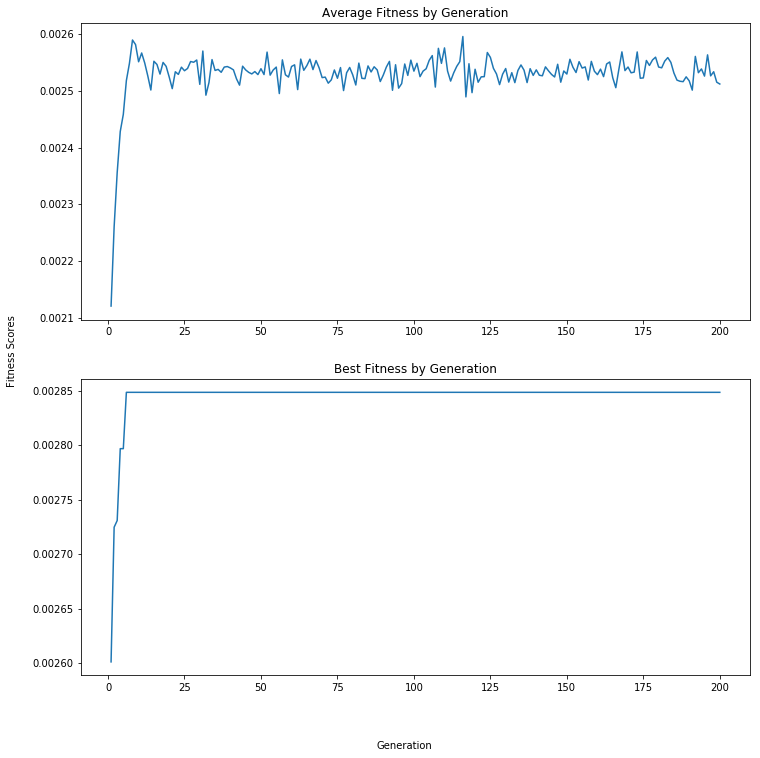

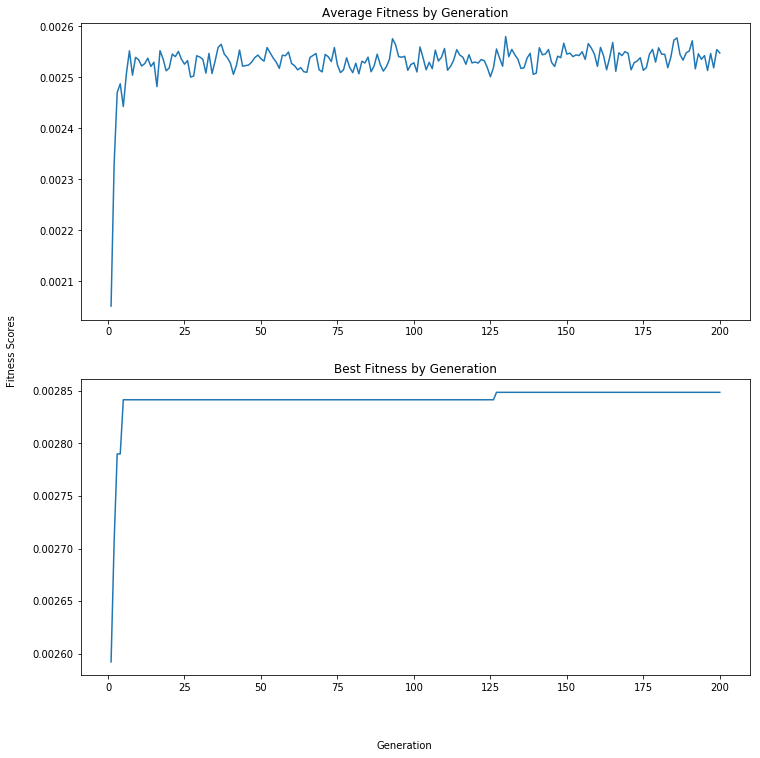

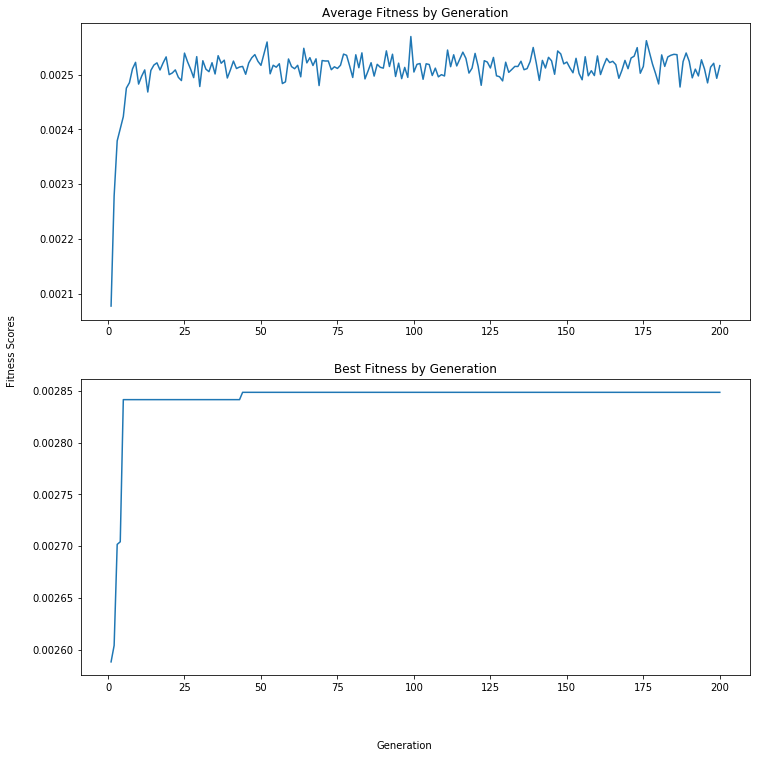

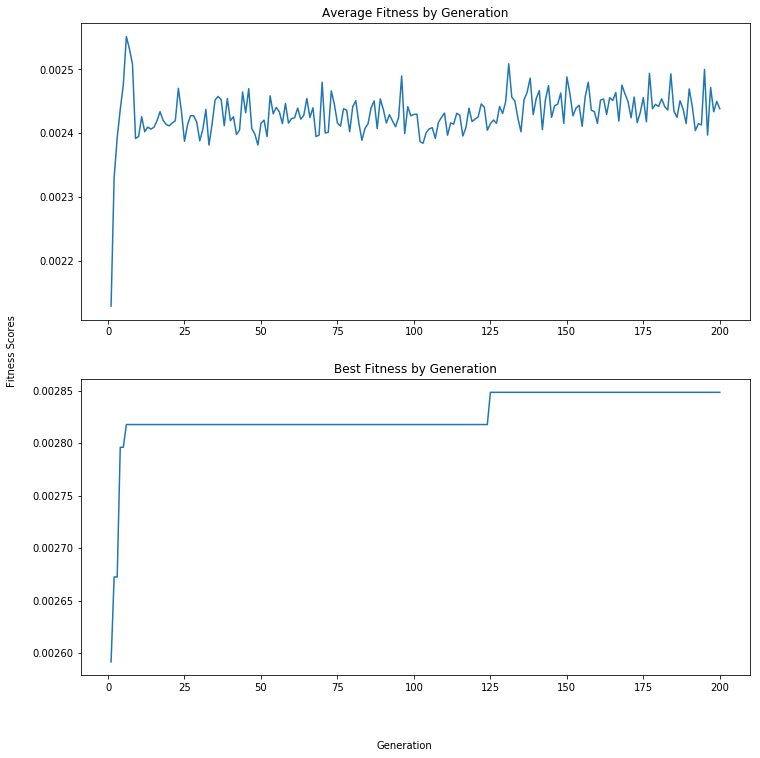

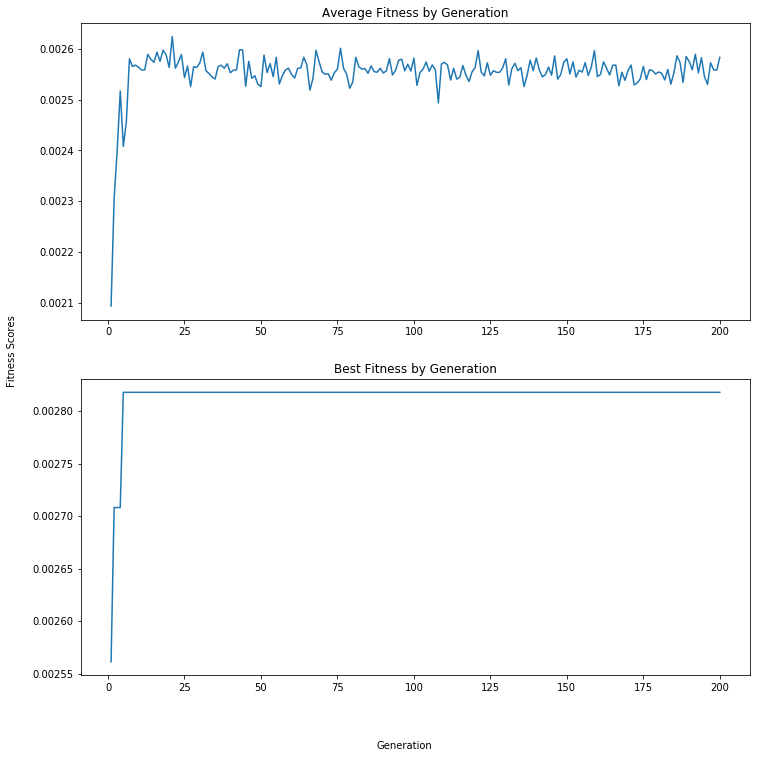

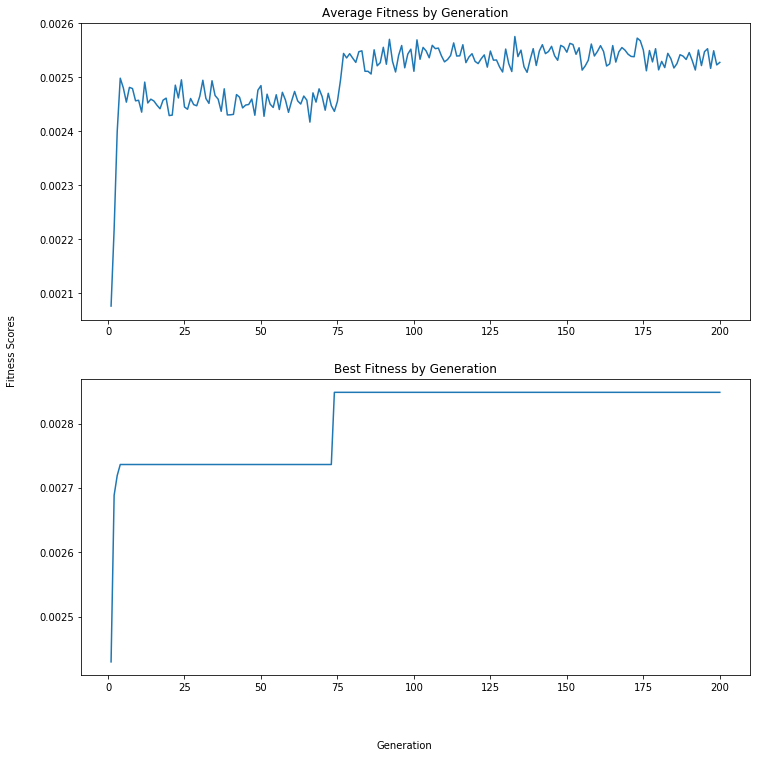

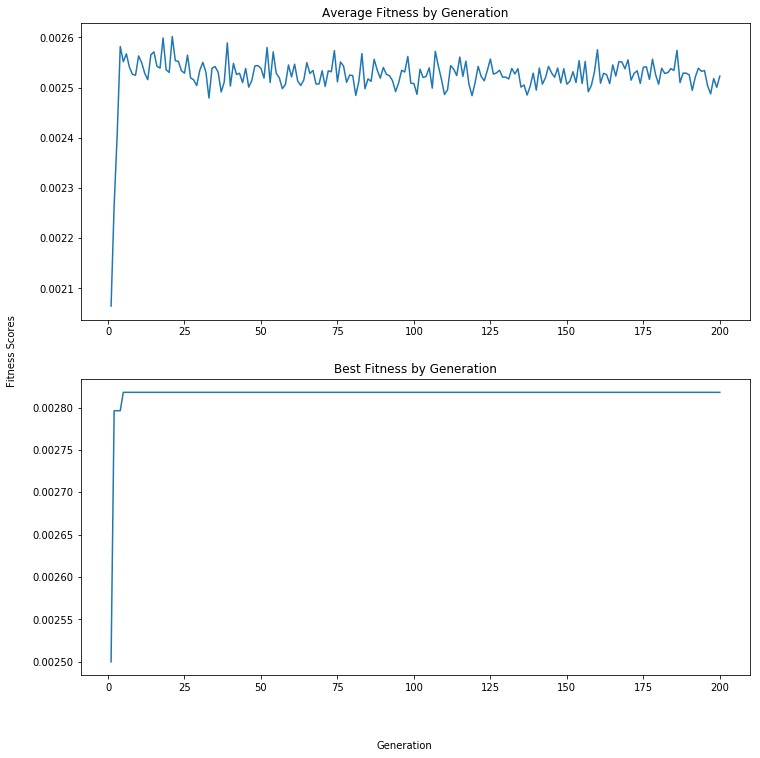

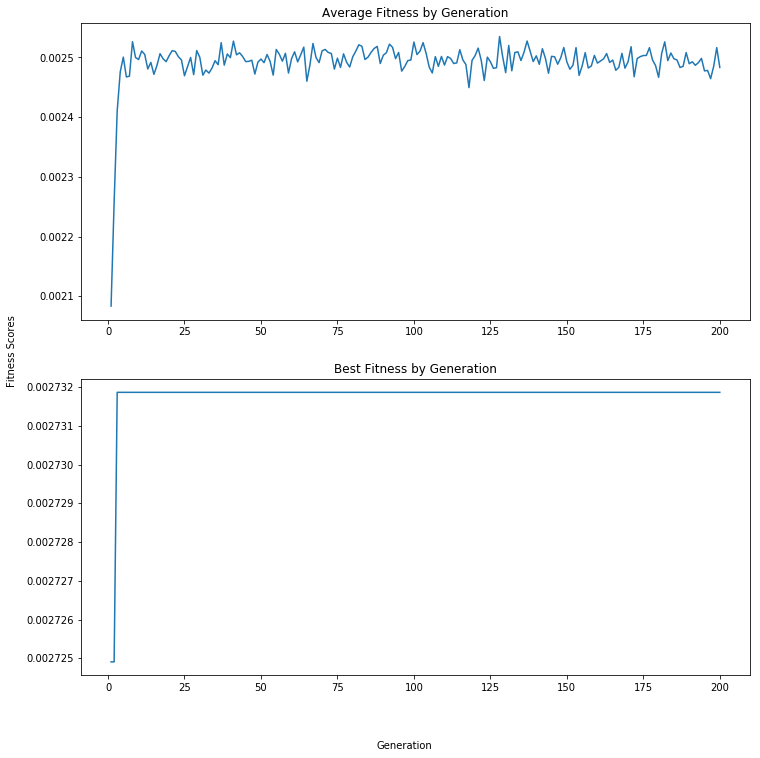

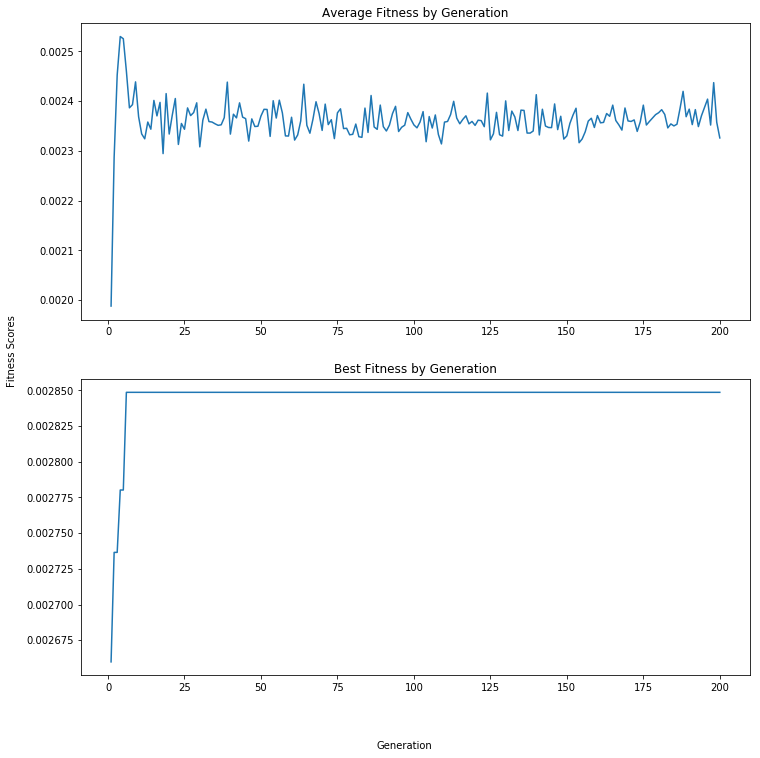

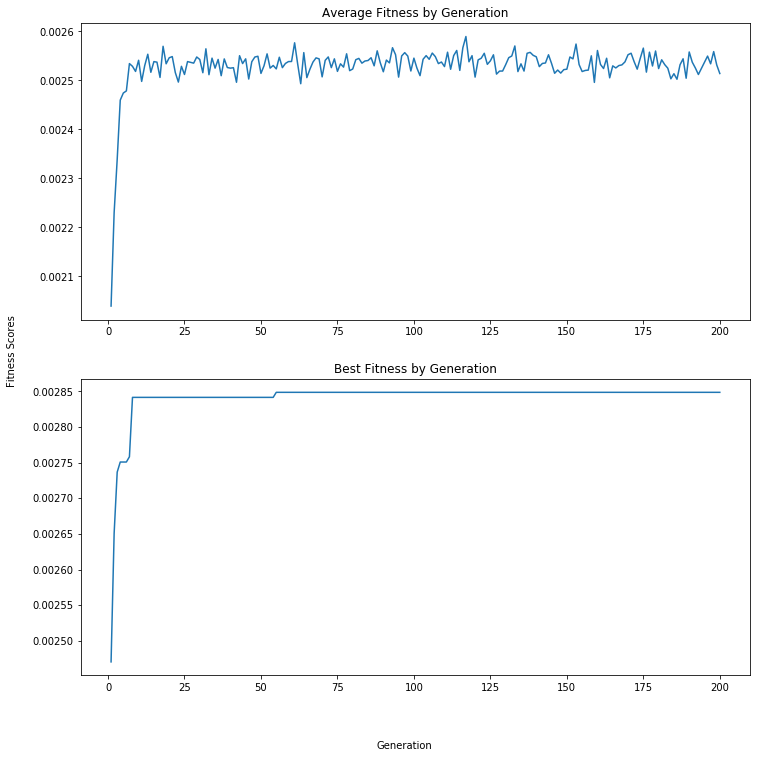

In [11]:
#Read in tsp file
nodes = read_tsp("Random11.tsp")

dists = []
times = []
best_dist = math.inf
best_path = None
paths = []

#Run ga algorithm 10 times
for i in range(0,10):
    start_time = time.time()
    dist, path = run_ga_tsp(nodes, 200, 0.01, 200, 10, rank_population_elite)
    run_time = time.time()-start_time
    times.append(run_time)
    dists.append(dist)
    paths.append(path)
    if dist < best_dist:
        best_dist = dist
        best_path = path
        
        
print("Best Path: ")
print(best_path)
print("Distance Statistics: ")
print(stats.describe(dists))
print("Time Statistics: ")
print(stats.describe(times))

In [117]:
adj_matrix = count_connections(paths, 11)
beta1 = cost_transform(adj_matrix, 1, 1)
beta3 = cost_transform(adj_matrix, 3, 3)

print(adj_matrix)
print()
print(beta1)
print()
print(beta3)

[[0.         0.         0.         0.         0.         0.72727273
  0.81818182 0.         0.         0.09090909 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.90909091 0.         0.90909091]
 [0.         0.         0.         0.         0.         0.
  0.90909091 0.         0.         0.72727273 0.18181818]
 [0.         0.         0.         0.         0.90909091 0.72727273
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.90909091 0.         0.
  0.         0.         0.81818182 0.         0.        ]
 [0.72727273 0.         0.         0.72727273 0.         0.
  0.         0.18181818 0.         0.         0.        ]
 [0.81818182 0.         0.90909091 0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.18181818
  0.         0.         0.         0.45454545 0.72727273]
 [0.         0.90909091 0.      